In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from numpy import array
from openturns import *
from openturns.viewer import View
# set seed for random number generator to assure the reproducibility of the analysis
RandomGenerator.SetSeed(1)
# set command to call R from within the python script
ResourceMap.Set('R-executable-command', 'R')

# Step A - Model definition

In [3]:
dim = 4
model = SymbolicFunction(["E", "F", "L", "I"], ["F*L^3/(3*E*I)"])

# Step B - Modelling of the input uncertainty

We first define the marginal distributions

In [4]:
# Young's modulus E: data-based kernel distribution
kernel = KernelSmoothing()
sample = Sample.ImportFromCSVFile("sample_E.csv")  # in Pa
dist_E = kernel.build(sample)

# Load F: lognormal
F_para = LogNormalMuSigma(3e4, 9e3, 15e3) # in N
dist_F = ParametrizedDistribution(F_para)

# Length L: uniform
dist_L = Uniform(250, 260) # in cm

# Moment of inertia I: beta
dist_I = Beta(2.5, 4, 310., 450.) # in cm^4
#dist_E.computeQuantile(0.5)

Draw the CDF of the parameters, e.g. the Young's modulus E

/home/blondet/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


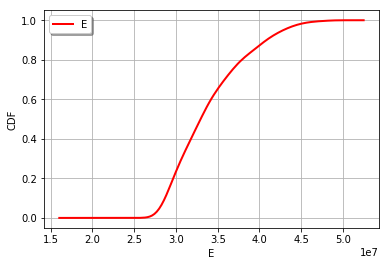

In [5]:
graph = dist_E.drawCDF()
graph.setLegends(['E'])
graph.setTitle('')
graph.setXTitle('E')
View(graph).show()

/home/blondet/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


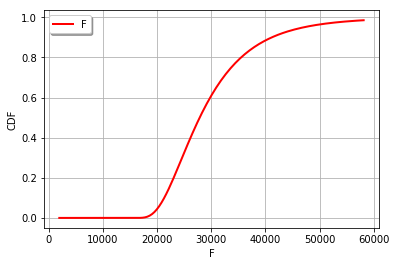

In [6]:
graph = dist_F.drawCDF()
graph.setLegends(['F'])
graph.setTitle('')
graph.setXTitle('F')
View(graph).show()

Then we specify the copula: a Gaussian copula is assumed

In [7]:
R = CorrelationMatrix(dim)
R[2,3] = -.2 # specify the correlation between variables IFF necessary, otherwise the standard correlation matrix is a unit matrix
myCopula = NormalCopula(NormalCopula.GetCorrelationFromSpearmanCorrelation(R)) # be sure to introduce the Pearson correlation matrix

Lastly we gather the marginals and the copula to create the joint distribution of the inputs

In [8]:
myDistribution = ComposedDistribution([dist_E, dist_F, dist_L, dist_I], myCopula)
# generate a set of values of the random parameters
X = myDistribution.getSample(10)

# Step C - Uncertainty propagation based on polynomial chaos

## Construct the polynomial chaos approximation

The types of 1D polynomial families are defined

In [9]:
polyColl = PolynomialFamilyCollection(dim)
polyColl[0] = StandardDistributionPolynomialFactory(dist_E)
polyColl[1] = LaguerreFactory() # beware of ad-hoc polynomials with the lognormal distribution
polyColl[2] = StandardDistributionPolynomialFactory(dist_L)
polyColl[3] = StandardDistributionPolynomialFactory(dist_I)

Define the strategy for enumerating the elements of the multivariate tensorized basis

In [10]:
enumerateFunction = EnumerateFunction(dim)

Determine the number of elements to be retained in the chaos series

In [11]:
p = 7 # total degree, integer
P = enumerateFunction.getStrataCumulatedCardinal(p) # number of chaos terms

Define the multivariate basis

In [12]:
multivariateBasis = OrthogonalProductPolynomialFactory(polyColl, enumerateFunction)

Specify the strategy for computing the chaos coefficients: sparse least squares (based on Least Angle Regression)

In [14]:
basisSequenceFactory = LARS()
fittingAlgorithm = CorrectedLeaveOneOut()
approximationAlgorithm = LeastSquaresMetaModelSelectionFactory(basisSequenceFactory, fittingAlgorithm)
N = 500 # size of the experimental design
evalStrategy = LeastSquaresStrategy(MonteCarloExperiment(N), approximationAlgorithm) # Monte Carlo design
truncatureBasisStrategy = FixedStrategy(multivariateBasis, P)

Construct the chaos metamodel

In [15]:
polynomialChaosAlgorithm = FunctionalChaosAlgorithm(model, myDistribution, truncatureBasisStrategy, evalStrategy)
polynomialChaosAlgorithm.run()

Get the result

In [16]:
result = polynomialChaosAlgorithm.getResult()
metamodel = result.getMetaModel()
chaosRV = FunctionalChaosRandomVector(result)

## Validate the metamodel

Generate a validation sample (different from the training sample)

In [17]:
n_valid = 1000
inputSample = myDistribution.getSample(n_valid)
outputSample = model(inputSample)

Get the corresponding chaos-based predictions

In [18]:
outputChaosSample = metamodel(inputSample)

Compute the relative mean-square accuracy (so-called Q2 coefficient)

In [19]:
residuals = outputSample - outputChaosSample
Q2 = 1. - residuals.computeVariance()[0] / outputSample.computeVariance()[0]
print("Q2 coefficient (relative accuracy): %.4f" % Q2)

Q2 coefficient (relative accuracy): 0.9940


Plot the actual vs the predicted outputs

/home/blondet/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


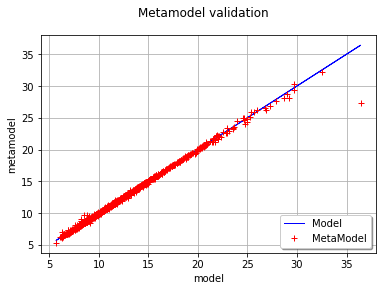

In [20]:
val = MetaModelValidation(inputSample, outputSample, metamodel)
graph = val.drawValidation()
View(graph).show()

## Post-processing of the chaos expansion

### Computation of the output mean and standard deviation from the chaos coefficients

In [21]:
print("Mean: %f" % chaosRV.getMean()[0])
print("Standard deviation: %f" % sqrt(chaosRV.getCovariance()[0,0]))

Mean: 12.599835
Standard deviation: 4.225456


Draw the empirical PDF of the response obtained with Kernel density estimation technique

/home/blondet/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


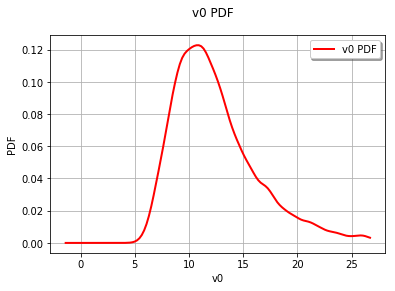

In [22]:
inputBigSample = myDistribution.getSample(10000)
outputBigsample = metamodel(inputBigSample)
kernel2 = KernelSmoothing()
fittedDist = kernel2.build(outputBigsample)
graph = fittedDist.drawPDF()
View(graph).show()

### Computation of Sobol' sensitivity indices

In [23]:
# Main-effects
for i, Xi in enumerate(["E", "F", "L", "I"]):
    sobolIndex = chaosRV.getSobolIndex(i)
    print("Sobol' sensitivity index to "+Xi+":    %f" %sobolIndex)

# Total indices
for i, Xi in enumerate(["E", "F", "L", "I"]):
    sobolTotalIndex = chaosRV.getSobolTotalIndex(i)
    print("Total Sobol' sensitivity index to "+Xi+":    %f" %sobolTotalIndex)

Sobol' sensitivity index to E:    0.146777
Sobol' sensitivity index to F:    0.758177
Sobol' sensitivity index to L:    0.022748
Sobol' sensitivity index to I:    0.051536
Total Sobol' sensitivity index to E:    0.161687
Total Sobol' sensitivity index to F:    0.777249
Total Sobol' sensitivity index to L:    0.025286
Total Sobol' sensitivity index to I:    0.056561


In [24]:
# interaction effects between first and second variables
chaosRV.getSobolTotalIndex([0,1])

0.01363301873697246

### Reliability analysis using polynomial chaos and MCS

In [30]:
# Reliability analysis using a (large) Monte Carlo sample of the chaos approximation
#
threshold = 30
myEvent = Event(chaosRV, ComparisonOperator(Greater()), threshold)
myEvent.setName("Deviation > 30 cm")
#
maximumOuterSampling = 40000
blockSize = 100
coefficientOfVariation = 0.10
#
experiment = MonteCarloExperiment()
myAlgoMonteCarlo = ProbabilitySimulationAlgorithm(myEvent, experiment)
myAlgoMonteCarlo.setMaximumOuterSampling(maximumOuterSampling)
myAlgoMonteCarlo.setBlockSize(blockSize)
myAlgoMonteCarlo.setMaximumCoefficientOfVariation(coefficientOfVariation)
myAlgoMonteCarlo.setConvergenceStrategy(HistoryStrategy(Full()))
#
myAlgoMonteCarlo.run()

Number of evaluations of the limit state function =  20300
Monte Carlo probability estimation =  0.004975369458128081
Variance of the Monte Carlo probability estimator =  2.463132938447585e-07
0.95 Confidence Interval = [ 0.0040026401148397376 ,  0.005948098801416424 ]



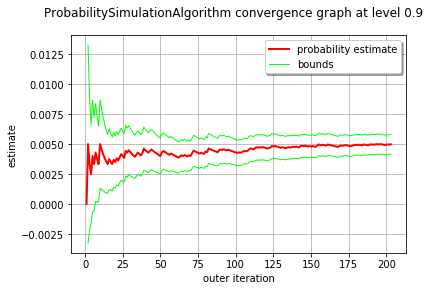

In [32]:
print( "Number of evaluations of the limit state function = ", myAlgoMonteCarlo.getResult().getOuterSampling()* myAlgoMonteCarlo.getResult().getBlockSize() )
print( "Monte Carlo probability estimation = ", myAlgoMonteCarlo.getResult().getProbabilityEstimate() )
print( "Variance of the Monte Carlo probability estimator = ", myAlgoMonteCarlo.getResult().getVarianceEstimate() )
print( "0.95 Confidence Interval = [", myAlgoMonteCarlo.getResult().getProbabilityEstimate() - 0.5*myAlgoMonteCarlo.getResult().getConfidenceLength(0.95), ", ", myAlgoMonteCarlo.getResult().getProbabilityEstimate() + 0.5*myAlgoMonteCarlo.getResult().getConfidenceLength(0.95), "]" )
print( "" )
alpha = 0.90 
convergenceGraphMonteCarlo = myAlgoMonteCarlo.drawProbabilityConvergence(alpha) 
#convergenceGraphMonteCarlo.draw("convergenceGrapheMonteCarlo", 640, 480) 


#convergence_graph_monte_carlo = algo_monte_carlo.drawProbabilityConvergence(alpha)
View(convergenceGraphMonteCarlo)

### Reliability analysis using analytical model and MCS

Number of evaluations of the limit state function =  16900
Monte Carlo probability estimation =  0.006035502958579883
Variance of the Monte Carlo probability estimator =  3.5853063356948454e-07
0.95 Confidence Interval = [ 0.004861926942799674 ,  0.007209078974360092 ]



/home/blondet/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


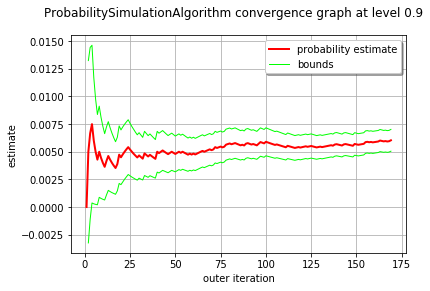

In [36]:
X_random_vector = RandomVector(Distribution(myDistribution))
G = RandomVector( model, X_random_vector)

threshold = 30
myEvent = Event(G, ComparisonOperator(Greater()), threshold)
myEvent.setName("Deviation > 30 cm")
#
maximumOuterSampling = 40000
blockSize = 100
coefficientOfVariation = 0.10
#
experiment = MonteCarloExperiment()
myAlgoMonteCarlo = ProbabilitySimulationAlgorithm(myEvent, experiment)
myAlgoMonteCarlo.setMaximumOuterSampling(maximumOuterSampling)
myAlgoMonteCarlo.setBlockSize(blockSize)
myAlgoMonteCarlo.setMaximumCoefficientOfVariation(coefficientOfVariation)
myAlgoMonteCarlo.setConvergenceStrategy(HistoryStrategy(Full()))
#
myAlgoMonteCarlo.run()

print( "Number of evaluations of the limit state function = ", myAlgoMonteCarlo.getResult().getOuterSampling()* myAlgoMonteCarlo.getResult().getBlockSize() )
print( "Monte Carlo probability estimation = ", myAlgoMonteCarlo.getResult().getProbabilityEstimate() )
print( "Variance of the Monte Carlo probability estimator = ", myAlgoMonteCarlo.getResult().getVarianceEstimate() )
print( "0.95 Confidence Interval = [", myAlgoMonteCarlo.getResult().getProbabilityEstimate() - 0.5*myAlgoMonteCarlo.getResult().getConfidenceLength(0.95), ", ", myAlgoMonteCarlo.getResult().getProbabilityEstimate() + 0.5*myAlgoMonteCarlo.getResult().getConfidenceLength(0.95), "]" )
print( "") 
alpha = 0.90 
convergenceGraphMonteCarlo = myAlgoMonteCarlo.drawProbabilityConvergence(alpha) 
#convergenceGraphMonteCarlo.draw("convergenceGrapheMonteCarlo", 640, 480) 


#convergence_graph_monte_carlo = algo_monte_carlo.drawProbabilityConvergence(alpha)
View(convergenceGraphMonteCarlo).show()